In [1]:
from collections import Counter

import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 1. 读取数据 ==========
file_path = "./按照stage标注.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# ========== 2. 解析 mermaid 成 graph ==========
def parse_mermaid_to_graph(mermaid_code: str, system_name: str):
    """
    将 mermaid sequenceDiagram 解析为有向图 (networkx.DiGraph)
    节点: 动作 (label)，带属性：actor, output, stage, system
    边: 时序关系 (按代码顺序)
    """
    G = nx.DiGraph(system=system_name)
    lines = mermaid_code.splitlines()
    current_stage = None
    node_id = 0
    last_node = None
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.lower().startswith(("alt", "else", "end")):
            continue
        # 识别阶段
        stage_match = re.match(r"note over H,A:\s*(.+)", line, re.IGNORECASE)
        if stage_match:
            current_stage = stage_match.group(1).strip()
            continue
        # 识别动作
        action_match = re.match(r"(H|A)\s*->>+\s*(H|A):\s*(.+)", line)
        if action_match:
            actor = action_match.group(1)
            action_text = action_match.group(3).strip()
            
            # 分解动作名和输出
            action_name, output = None, None
            if "[" in action_text and "]" in action_text:
                parts = re.match(r"(.+?)\s*\[(.+)\]", action_text)
                if parts:
                    action_name = parts.group(1).strip()
                    output = parts.group(2).strip()
                else:
                    action_name = action_text
            else:
                action_name = action_text
            
            node_id += 1
            node_key = f"{system_name}_{node_id}"
            G.add_node(node_key, 
                       system=system_name,
                       actor=actor,
                      #  year=
                       action=action_name,
                       output=output,
                       stage=current_stage)
            
            if last_node:
                G.add_edge(last_node, node_key)
            last_node = node_key
    return G

# ========== 3. 构建所有系统的 graph ==========
all_graphs = {}
for idx, row in df.iterrows():
    system_name = row["System"]
    mermaid_code = row["update uml with stage"]
    G = parse_mermaid_to_graph(mermaid_code, system_name)
    all_graphs[system_name] = G

# ========== 4. 提取所有节点信息 ==========
all_nodes = []
for system, G in all_graphs.items():
    for n, data in G.nodes(data=True):
        all_nodes.append((system, data.get("stage"), data.get("actor"), data.get("action"), data.get("output")))

nodes_df = pd.DataFrame(all_nodes, columns=["system", "stage", "actor", "action", "output"])
nodes_df["stage"] = nodes_df["stage"].str.title()
nodes_df.to_csv("nodes_df.csv")

In [2]:
import pandas as pd
import altair as alt
from collections import defaultdict

def build_collab_matrix(nodes_df, stage_keyword, mapping_rules, plot_title="Human-AI Collaboration Matrix",color_scheme="redblue"):
    """
    构建 Human-AI 协作矩阵，返回:
      - contribution_matrix: pd.DataFrame, 行为 Human 角色，列为 AI 角色（含 "None"）
      - chart: Altair 图（0 白底、有边框、redblue 配色、数字标注、tooltip 显示论文）
      - pair_detail_df: pd.DataFrame，矩阵每个格子的论文清单

    统计逻辑:
      只统计 Human 动作后紧邻的 AI 响应；若 Human 后无紧邻 AI，则记到 AI=None。
      若某篇文章在该阶段仅有 1 个动作，则 H-only 记 HumanRole→None，A-only 记 None→AIRole。
    """

    # --- 动作→角色映射 ---
    def map_action_to_role(action):
        for role, actions in mapping_rules.items():
            for verb in actions:
                if verb.lower() in str(action).lower():
                    return role
        return "None"

    # --- 筛选目标阶段 ---
    stage_df = nodes_df[nodes_df["stage"].str.lower().str.contains(stage_keyword.lower())].copy()
    stage_df['role'] = stage_df['action'].apply(lambda x: map_action_to_role(x))

    # --- 角色集合（含 "None"） ---
    roles_set = sorted(set(mapping_rules.keys()))
    all_roles_with_none = roles_set + ["None"]

    # 矩阵
    contribution_matrix = pd.DataFrame(
        0, index=all_roles_with_none, columns=all_roles_with_none, dtype=int
    )
    
    # 记录每个格子的论文集合
    pair_papers = defaultdict(set)

    # --- 遍历文章，累计 Human→AI 相邻对 ---
    for system_name, group in stage_df.groupby("system"):
        sorted_group = group.sort_index().reset_index(drop=True)
        n = len(sorted_group)

        if n == 1:
            row = sorted_group.iloc[0]
            if row['actor'] == "H":
                h_role, a_role = row['role'], "None"
                contribution_matrix.loc[h_role, a_role] += 1
                pair_papers[(h_role, a_role)].add(system_name)
            else:
                h_role, a_role = "None", row['role']
                contribution_matrix.loc[h_role, a_role] += 1
                pair_papers[(h_role, a_role)].add(system_name)
            continue
          

        for i in range(n - 1):
            row = sorted_group.iloc[i]
            next_row = sorted_group.iloc[i + 1]
            
            # 只统计 Human→AI 的转移
            if row['actor'] == 'H':
                h_role = row['role']
                # 确定AI角色（考虑下一个可能是未映射的AI动作）
                if next_row['actor'] == 'A':
                    ai_role = next_row['role']
                else:
                    ai_role = "None"  # 下一个不是AI
                
                contribution_matrix.loc[h_role, ai_role] += 1
                pair_papers[(h_role, ai_role)].add(system_name)  # ✅ 记录论文

        # 处理序列结尾的人类动作
        last_row = sorted_group.iloc[-1]
        if last_row['actor'] == "H":
            h_role = last_row['role']
            contribution_matrix.loc[h_role, "None"] += 1
            pair_papers[(h_role, "None")].add(system_name)  # ✅ 记录论文
    
    total_count = contribution_matrix.values.sum()
    # print("Total transitions:", total_count)
    # --- 为可视化准备长表，并附上论文列表 ---
    plot_df = contribution_matrix.reset_index().melt(
        id_vars="index", var_name="AI Role", value_name="count"
    ).rename(columns={"index": "Human Role"})

    # 把论文集合拼接为字符串，供 tooltip 使用
    def papers_joined(hr, ar):
        s = pair_papers.get((hr, ar), set())
        if not s:
            return ""
        # 过长可截断或只取前若干篇
        return "; ".join(sorted(s))

    plot_df["papers"] = [
        papers_joined(hr, ar) for hr, ar in zip(plot_df["Human Role"], plot_df["AI Role"])
    ]
    plot_df["num_papers"] = plot_df["papers"].apply(lambda x: 0 if x == "" else len(x.split("; ")))

    # --- Altair 可视化 ---
    base = alt.Chart(plot_df).encode(
        x=alt.X("AI Role:O", sort=list(contribution_matrix.columns), axis=alt.Axis(labelFontSize=12, title="AI Roles")),
        y=alt.Y("Human Role:O", sort=list(contribution_matrix.index), axis=alt.Axis(labelFontSize=12, title="Human Roles")),
    )

    # 0 强制白色，其它用 redblue
    heatmap = base.mark_rect(stroke='black', strokeWidth=1).encode(
        color=alt.condition(
            "datum.count == 0",
            alt.value("white"),
            alt.Color(
                "count:Q",
                scale=alt.Scale(scheme=color_scheme),
                legend=alt.Legend(title="Count")
            )
        ),
        tooltip=[
            alt.Tooltip("Human Role:N", title="Human"),
            alt.Tooltip("AI Role:N", title="AI"),
            alt.Tooltip("count:Q", title="Count"),
            alt.Tooltip("num_papers:Q", title="#Papers"),
            alt.Tooltip("papers:N", title="Papers")
        ]
    )

    text = base.mark_text(baseline="middle").encode(
        text=alt.Text("count:Q", format="d"),
        color=alt.condition("datum.count > 7", alt.value("white"), alt.value("black"))
    )

    chart = (heatmap + text).properties(
        width=200, height=200, title=plot_title
    )

    # --- 明细表：每个格子对应的论文 ---
    rows = []
    for hr in all_roles_with_none:
        for ar in all_roles_with_none:
            papers = sorted(pair_papers.get((hr, ar), set()))
            rows.append({
                "Human Role": hr,
                "AI Role": ar,
                "count": int(contribution_matrix.loc[hr, ar]),
                "num_papers": len(papers),
                "papers": papers
            })
    pair_detail_df = pd.DataFrame(rows)
    pair_detail_df["ratio"] = pair_detail_df["count"] / total_count
    # print("pair_detail_df", pair_detail_df["ratio"])
    return contribution_matrix, chart, pair_detail_df


In [3]:
# Goal Setting 阶段
mapping_rules_goal = {
    "Specifier": [
        "Set", "Provide", "Specify", "Define", "Identify", "Decide", "Confirm", "Propose", "Submit","Ask", "Request", "Inquire", "Speak", "Write", "Input", "Query", "Issue", "Answer", "Send", "Clarify", "Talk"
    ],
    "Demonstrator": [
        "Demonstrate", "Draft", "Create", "Sketch", "Describe", "Show",
        "Explore", "Discuss", "Manipulate", "Interact", "Perform", "Browse", "Continue", "View"
    ],
    "Selector": [
        "Select", "Sample", "Rank", "Apply", "Insert", "Choose", "Curate"
    ],
    "Recommender": [
        "Recommend", "Suggest", "Ideate", "Steer", "Guide", "Support"
    ],
    "Updater": [
        "Load", "Upload", "Execute", "Run", "Plan", "Transform", "Compile", "Parse", "Slice", 
        "Decompose", "Build", "Sync", "Update", "Revise", "Retrain", "Recompute", "Adapt", 
        "Refine", "Adjust", "Modify", "Edit", "Filter", "Merge", "Split", "Improve", "Learn",
        "Validate", "Correct", "Reorganize"
    ]
}
goal_matrix, goal_chart, detail_goal = build_collab_matrix(nodes_df, "goal setting", 
                                                           mapping_rules_goal, "Goal Setting", "purples")
goal_chart.show()
goal_chart.save("goal_chart.svg")

mapping_rules_dataprep_final = {
    "Interpreter": [
        "Parse", "Slice", "Extract", "Detect", "Compile", "Interpret", "Monitor", "Map", "Retrieve"
    ],
    "Transformer": [
        "Configure", "Apply", "Specify", "Correct", "Edit", "Modify"
    ],
    "Executor": [
        "Run", "Build", "Plan", "Update", "Decompose", "Initialize", "Upload", "Provide"
    ],
    "Analyzer": [
        "Compute", "Infer", "Analyze", "Generate", "Discover", "Classify", "Synthesize",
        "Create", "Sketch", "Rank"
    ],
    "Recommender": [
        "Recommend", "Suggest", "Present", "Approve", "Confirm", "Answer",
        "Clarify", "Show", "Explain", "Verify", "Send", "Refine", "Curate"
    ]
}
# Data Preparation 阶段
dataprep_matrix, data_chart, detail_data = build_collab_matrix(nodes_df, "data preparation", mapping_rules_dataprep_final, "Data Preparation", "oranges")
data_chart.show()
data_chart.save("data_chart.svg")


mapping_rules_vis = {
    "Generator": ["Generate", "Render", "Visualize", "Embed", "Interpolate", "Summarize"],
    "Presenter": ["Show", "Present", "Display", "Respond"],
    "Explorer": ["Explore", "Hover", "Browse", "Inspect", "View", "Perform", "Execute"],
    "Recommender": ["Recommend", "Suggest", "Guide"],
    "Updater": [
        "Update", "Adjust", "Modify", "Configure", "Apply", "Edit", "Insert",
        "Refine", "Remap", "Group", "Confirm", "Infer", "Validate", "Collaborate",
        "Analyze", "Write", "Provide"
    ]
}

vis_matrix, vis_chart, detail_vis = build_collab_matrix(nodes_df, "visualization", mapping_rules_vis, "Visualization", "blues")
vis_chart.show()
vis_chart.save("vis_chart.svg")

mapping_rules_insight = {
    "Producer": [
        "Generate", "Present", "Produce", "Deliver", "Summarize",
        "Export", "Output", "Report", "Text", "Record", "Organize",
        "Construct", "Display"
    ],
    "Evaluator": [
        "Accept", "Reject", "Verify", "Evaluate", "Interpret", "Inspect",
        "Identify", "Review", "Validate", "Decide", "Confirm"
    ],
    "Refiner": [
        "Refine", "Revise", "Adjust", "Modify", "Correct", "Improve",
        "Update", "Reorganize", "Recompute", "Adapt", "Sync", "Paraphrase",
        "Edit", "Change", "Highlight", "Re-rank", "Remove", "Respond"
    ],
    "Recommender": [
        "Recommend", "Suggest", "Infer", "Support", "Explain", "Propose",
        "Guide", "Annotate"
    ],
    "Selector": [
        "Select", "Provide", "Ask", "Give", "Apply", "Choose", "Query",
        "Continue", "Commit", "Save", "Filter", "Curate", "Merge", "Split",
        "Browse", "Integrate"
    ]
}
insight_matrix, insight_chart, detail_insight = build_collab_matrix(nodes_df, "insight synthesis", mapping_rules_insight, "Insight Synthesis","teals")
insight_chart.show()
insight_chart.save("insight_chart.svg")

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

In [4]:
mapping_rules_all = {
    "Goal Setting": mapping_rules_goal,
    "Data Preparation": mapping_rules_dataprep_final,
    "Visualization": mapping_rules_vis,
    "Insight Synthesis": mapping_rules_insight
}

# Step 1: 按 actor 分列
nodes_df["AI Actions"] = nodes_df.apply(lambda x: x["action"] if x["actor"] == "A" else None, axis=1)
nodes_df["Human Actions"] = nodes_df.apply(lambda x: x["action"] if x["actor"] != "A" else None, axis=1)

# Step 2: 映射 actions -> roles
def map_roles(row, target):
    rules = mapping_rules_all.get(row["stage"], {})
    action = row[target]
    if action is None:
        return None
    for role, verbs in rules.items():
        for v in verbs:
            if v.lower() in action.lower():  # 只要匹配到一个就返回
                return role
    return None

nodes_df["AI Roles"] = nodes_df.apply(lambda x: map_roles(x, "AI Actions"), axis=1)
nodes_df["Human Roles"] = nodes_df.apply(lambda x: map_roles(x, "Human Actions"), axis=1)

# Step 3: 按 Paper + Stage 聚合
agg_df = nodes_df.groupby(["system", "stage"], sort=False).agg({
    "AI Roles": lambda x: list(sorted(set([i for i in x if i is not None]))),
    "Human Roles": lambda x: list(sorted(set([i for i in x if i is not None])))
}).reset_index()

# 重命名列
agg_df = agg_df.rename(columns={
    "system": "Paper",
    "stage": "Stage"
})

# Step 4: 保存
agg_df.to_csv("666.csv", index=False)


In [5]:
agg_df

,Paper,Stage,AI Roles,Human Roles
0,Towards Visual Explainable Active Learning for...,Goal Setting,[Specifier],[]
1,Towards Visual Explainable Active Learning for...,Insight Synthesis,"[Recommender, Refiner]",[Refiner]
2,EXMOS: Explanatory Model Steering Through Mult...,Goal Setting,[Specifier],[]
3,EXMOS: Explanatory Model Steering Through Mult...,Data Preparation,[Recommender],"[Recommender, Transformer]"
4,EXMOS: Explanatory Model Steering Through Mult...,Visualization,[Updater],[]
...,...,...,...,...
204,ConceptEVA,Visualization,[Generator],[]
205,CrossData,Goal Setting,[],[Specifier]
206,CrossData,Data Preparation,[Interpreter],[]
207,CrossData,Visualization,[Updater],[Updater]


In [414]:
import pandas as pd
from collections import defaultdict
import numpy as np

def get_paper_roles_by_stage(nodes_df, mapping_rules_all):
    """
    Generates a detailed list of roles for each paper and stage.

    Args:
      nodes_df (pd.DataFrame): DataFrame with 'system', 'stage', 'actor', 'action', and 'year' columns.
      mapping_rules_all (dict): A nested dictionary with mapping rules for each stage.

    Returns:
      pd.DataFrame: A DataFrame containing a detailed list of Human and AI roles for each paper and stage.
    """

    # --- Unified action-to-role mapping function ---
    def map_action_to_role_global(action, stage_keyword):
        # Select the correct mapping rules based on the stage
        stage_rules = mapping_rules_all.get(stage_keyword.lower(), {})
        for role, actions in stage_rules.items():
            for verb in actions:
                if verb.lower() in str(action).lower():
                    return role
        return "None"

    # Prepare an empty list to collect all results
    all_rows = []

    # Iterate through each paper
    for system_name, paper_group in nodes_df.groupby("system", sort=False):
        
        # Retrieve the year for the current paper from its group
        # We use .iloc[0] because all rows in the group should have the same year
        year = paper_group['year'].iloc[0]
        
        # Iterate through each stage within the paper
        for stage_name, stage_group in paper_group.groupby("stage"):
            
            human_roles = set()
            ai_roles = set()
            
            # Iterate through each action in this stage
            for _, row in stage_group.iterrows():
                role = map_action_to_role_global(row['action'], stage_name)
                
                if row['actor'] == 'H' and role != 'None':
                    human_roles.add(role)
                elif row['actor'] == 'A' and role != 'None':
                    ai_roles.add(role)
            
            all_rows.append({
                "Paper": system_name,
                "Stage": stage_name,
                "Human Roles": sorted(list(human_roles)),
                "AI Roles": sorted(list(ai_roles)),
                "Year": year
            })

    return pd.DataFrame(all_rows)

# --- Example Usage (Assuming nodes_df and mapping_rules_all are defined) ---
# Example: Create a dummy nodes_df for demonstration
# nodes_df = pd.DataFrame({
#     "system": ["PaperA", "PaperA", "PaperB", "PaperB"],
#     "stage": ["Goal Setting", "Data Preparation", "Goal Setting", "Data Preparation"],
#     "actor": ["H", "A", "H", "A"],
#     "action": ["specify", "generate", "explore", "transform"],
#     "Year": [2022, 2022, 2023, 2023]
# })

# Example: Define mapping rules
# mapping_rules_goal = {"Specifier": ["specify"], "Explorer": ["explore"]}
# mapping_rules_dataprep_final = {"Generator": ["generate"], "Transformer": ["transform"]}
# mapping_rules_all = {
#     "goal setting": mapping_rules_goal,
#     "data preparation": mapping_rules_dataprep_final
# }

# Run the function and generate the table
final_table = get_paper_roles_by_stage(nodes_df, mapping_rules_all)
# print(final_table)

# If you want to save to a CSV file
final_table.to_csv("paper_roles_by_stage.csv")

In [218]:
def build_ai_to_human_matrix(nodes_df, stage_keyword, mapping_rules, plot_title="AI-Human Response Matrix", color_scheme="greens"):
    """
    构建 AI→Human 响应矩阵，但保持矩阵结构一致性:
      - 行: Human 角色 (响应者)
      - 列: AI 角色 (发起者)
    """

    # --- 动作→角色映射 ---
    def map_action_to_role(action):
        for role, actions in mapping_rules.items():
            for verb in actions:
                if verb.lower() in str(action).lower():
                    return role
        return "None"

    # --- 筛选目标阶段 ---
    stage_df = nodes_df[nodes_df["stage"].str.lower().str.contains(stage_keyword.lower())].copy()
    stage_df['role'] = stage_df['action'].apply(lambda x: map_action_to_role(x))

    # --- 角色集合（含 "None"） ---
    roles_set = sorted(set(mapping_rules.keys()))
    all_roles_with_none = roles_set + ["None"]

    # 矩阵结构：行=Human角色，列=AI角色（保持与Human→AI矩阵一致）
    response_matrix = pd.DataFrame(
        0, index=all_roles_with_none, columns=all_roles_with_none, dtype=int
    )

    # 记录每个格子的论文集合
    pair_papers = defaultdict(set)

    # --- 遍历文章，累计 AI→Human 相邻对 ---
    for system_name, group in stage_df.groupby("system"):
        sorted_group = group.sort_index().reset_index(drop=True)
        n = len(sorted_group)

        # 处理只有1个动作的情况
        if n == 1:
            row = sorted_group.iloc[0]
            if row['actor'] == "A":  # 只有AI动作
                ai_role, human_role = row['role'], "None"
                response_matrix.loc[human_role, ai_role] += 1  # 注意：行列交换
                pair_papers[(human_role, ai_role)].add(system_name)
            continue
          
        # 处理多动作序列
        for i in range(n - 1):
            row = sorted_group.iloc[i]
            next_row = sorted_group.iloc[i + 1]
            
            # 只统计 AI→Human 的转移
            if row['actor'] == 'A':  # AI动作
                ai_role = row['role']
                if next_row['actor'] == 'H':  # 人类响应
                    human_role = next_row['role']
                else:
                    human_role = "None"  # 无人响应
                
                response_matrix.loc[human_role, ai_role] += 1  # 注意：行列交换
                pair_papers[(human_role, ai_role)].add(system_name)
        
        # 检查最后一个动作是否为AI动作（无人响应）
        last_row = sorted_group.iloc[-1]
        if last_row['actor'] == "A":
            ai_role = last_row['role']
            response_matrix.loc["None", ai_role] += 1  # 注意：行列交换
            pair_papers[("None", ai_role)].add(system_name)

    # --- 为可视化准备长表，并附上论文列表 ---
    plot_df = response_matrix.reset_index().melt(
        id_vars="index", var_name="AI Role", value_name="count"  # 保持列名为AI Role
    ).rename(columns={"index": "Human Role"})  # 保持行名为Human Role

    # 把论文集合拼接为字符串，供 tooltip 使用
    def papers_joined(hr, ar):
        s = pair_papers.get((hr, ar), set())
        if not s:
            return ""
        return "; ".join(sorted(s))

    plot_df["papers"] = [
        papers_joined(hr, ar) for hr, ar in zip(plot_df["Human Role"], plot_df["AI Role"])
    ]
    plot_df["num_papers"] = plot_df["papers"].apply(lambda x: 0 if x == "" else len(x.split("; ")))

    # --- Altair 可视化 ---
    base = alt.Chart(plot_df).encode(
        x=alt.X("AI Role:O", sort=list(response_matrix.columns), axis=alt.Axis(labelFontSize=12, title="AI Roles")),
        y=alt.Y("Human Role:O", sort=list(response_matrix.index), axis=alt.Axis(labelFontSize=12, title="Human Roles")),
    )

    # 0 强制白色，其它用指定配色
    heatmap = base.mark_rect(stroke='black', strokeWidth=1).encode(
        color=alt.condition(
            "datum.count == 0",
            alt.value("white"),
            alt.Color(
                "count:Q",
                scale=alt.Scale(scheme=color_scheme),
                legend=alt.Legend(title="Count")
            )
        ),
        tooltip=[
            alt.Tooltip("AI Role:N", title="AI Initiator"),  # AI发起者
            alt.Tooltip("Human Role:N", title="Human Responder"),  # 人类响应者
            alt.Tooltip("count:Q", title="Count"),
            alt.Tooltip("num_papers:Q", title="#Papers"),
            alt.Tooltip("papers:N", title="Papers")
        ]
    )

    text = base.mark_text(baseline="middle").encode(
        text=alt.Text("count:Q", format="d"),
        color=alt.condition("datum.count > 7", alt.value("white"), alt.value("black"))
    )

    chart = (heatmap + text).properties(
        width=200, height=200, title=plot_title
    )

    # --- 明细表：每个格子对应的论文 ---
    rows = []
    for hr in all_roles_with_none:
        for ar in all_roles_with_none:
            papers = sorted(pair_papers.get((hr, ar), set()))
            rows.append({
                "Human Role": hr,
                "AI Role": ar,
                "count": int(response_matrix.loc[hr, ar]),
                "num_papers": len(papers),
                "papers": papers
            })
    pair_detail_df = pd.DataFrame(rows)

    return response_matrix, chart, pair_detail_df
# Goal Setting 阶段的 AI→Human 矩阵
goal_ai2human_matrix, goal_ai2human_chart, detail_goal_ai2human = build_ai_to_human_matrix(
    nodes_df, "goal setting", mapping_rules_goal, "Goal Setting - AI to Human", "purples"
)
goal_ai2human_chart.show()
goal_ai2human_chart.save("goal_ai2human_chart.svg")

# Data Preparation 阶段的 AI→Human 矩阵
dataprep_ai2human_matrix, dataprep_ai2human_chart, detail_dataprep_ai2human = build_ai_to_human_matrix(
    nodes_df, "data preparation", mapping_rules_dataprep_final, "Data Preparation - AI to Human", "oranges"
)
dataprep_ai2human_chart.show()
dataprep_ai2human_chart.save("dataprep_ai2human_chart.svg")
# Visualization 阶段的 AI→Human 矩阵
vis_ai2human_matrix, vis_ai2human_chart, detail_vis_ai2human = build_ai_to_human_matrix(
    nodes_df, "visualization", mapping_rules_vis, "Visualization - AI to Human", "blues"
)
vis_ai2human_chart.show()
vis_ai2human_chart.save("vis_ai2human_chart.svg")
# Insight Synthesis 阶段的 AI→Human 矩阵
insight_ai2human_matrix, insight_ai2human_chart, detail_insight_ai2human = build_ai_to_human_matrix(
    nodes_df, "insight synthesis", mapping_rules_insight, "Insight Synthesis - AI to Human", "teals"
)
insight_ai2human_chart.show()
insight_ai2human_chart.save("insight_ai2human_chart.svg")

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

In [221]:
df_expanded_context

,Paper,Stage,Human modality,AI modality,Explanation
0,Zero-shot Classification,Goal Setting,Text,Text,AI 提问和解释系统状态以帮助设定目标，采用文字问题与说明。
1,Zero-shot Classification,Insight Synthesis,Text,Text,AI 推荐标签（文本），人反馈并修改；语义地图作为可视化。
2,Zero-shot Classification,Insight Synthesis,Text,Vis,AI 推荐标签（文本），人反馈并修改；语义地图作为可视化。
3,EXMOS,Goal Setting,Text,Text,AI 提供模型或数据解释，用文本加可视化的 dashboard。
4,EXMOS,Goal Setting,Text,Vis,AI 提供模型或数据解释，用文本加可视化的 dashboard。
...,...,...,...,...,...
265,ConceptEVA,Insight Synthesis,nan,Vis,AI 生成总结，用户选择概念并更新文本。
266,CrossData,Goal Setting,Text,nan,用户编写文本作为起点。
267,CrossData,Data Preparation,nan,Text,AI 检测并建立文本与数据连接。
268,CrossData,Visualization,Vis,nan,用户插入表格，AI 更新图表。


In [339]:
import pandas as pd
from itertools import product

# 读入你上传的 CSV
df = pd.read_csv("222.csv")

records = []
for _, row in df.iterrows():
    stage = row["Stage"]
    paper = row["Paper"]
    expl = row["Explanation"]
    humans = str(row["Human modality"]).split()
    ais = str(row["AI modality"]).split()
    for h, a in product(humans, ais):
        records.append((paper, stage, h, a, expl))

df_expanded_context = pd.DataFrame(
    records,
    columns=["Paper", "Stage", "Human modality", "AI modality", "Explanation"]
)
import altair as alt
import pandas as pd

def plot_stage_matrix(df, stage, color_scheme="redblue"):
    """
    df: DataFrame, 必须包含 Stage, Human modality, AI modality, Paper
    stage: string, 选择的分析阶段 (Goal Setting / Data Preparation / Visualization / Insight Synthesis)
    """
    plot_df = (
        df[df["Stage"] == stage]
        .groupby(["Human modality", "AI modality"])
        .agg(
            count=("Paper", "count"),
            papers=("Paper", lambda x: ", ".join(sorted(set(x)))),
            num_papers=("Paper", lambda x: len(set(x)))
        )
        .reset_index()
        .rename(columns={"Human modality": "Human Output", "AI modality": "AI Output"})
    )

    # 保证完整矩阵：所有 Human × AI 组合都出现（缺的补0）
    # all_humans = df["Human modality"].unique().tolist()
    all_humans = ['Text', 'Widget', 'Vis', 'Code', 'Speech', 'Sketch','nan']
    print(all_humans)
    # all_ais = df["AI modality"].unique().tolist()
    all_ais = all_humans
    full_index = pd.MultiIndex.from_product([all_humans, all_ais], names=["Human Output", "AI Output"])
    plot_df = (
        plot_df.set_index(["Human Output", "AI Output"])
        .reindex(full_index, fill_value=0)
        .reset_index()
    )

    base = alt.Chart(plot_df).encode(
        x=alt.X("AI Output:O", sort=all_ais, axis=alt.Axis(labelFontSize=12, title="AI Output")),
        y=alt.Y("Human Output:O", sort=all_humans, axis=alt.Axis(labelFontSize=12, title="Human Output")),
    )

    # Heatmap
    heatmap = base.mark_rect(stroke="black", strokeWidth=1).encode(
        color=alt.condition(
            "datum.count == 0",
            alt.value("white"),
            alt.Color(
                "count:Q",
                scale=alt.Scale(scheme=color_scheme),
                legend=alt.Legend(title="Count")
            )
        ),
        tooltip=[
            alt.Tooltip("Human Output:N", title="Human"),
            alt.Tooltip("AI Output:N", title="AI"),
            alt.Tooltip("count:Q", title="Count"),
            alt.Tooltip("num_papers:Q", title="#Papers"),
            alt.Tooltip("papers:N", title="Papers"),
        ]
    )

    # Text annotations
    text = base.mark_text(baseline="middle").encode(
        text=alt.Text("count:Q", format="d"),
        color=alt.condition("datum.count > 0", alt.value("white"), alt.value("black"))
    )

    chart = (heatmap + text).properties(
        width=200, height=200, title=f"{stage}"
    )

    return chart

# 画四个阶段
goal_chart = plot_stage_matrix(df_expanded_context, "Goal Setting", "reds")
goal_chart.show()
goal_chart.save()
prep_chart = plot_stage_matrix(df_expanded_context, "Data Preparation", "oranges")
prep_chart.show()
vis_chart = plot_stage_matrix(df_expanded_context, "Visualization", "blues")
vis_chart.show()
insight_chart = plot_stage_matrix(df_expanded_context, "Insight Synthesis", "teals")
insight_chart.show()

# 拼在一起
# final_chart = alt.hconcat(goal_chart, prep_chart, vis_chart, insight_chart)
# final_chart


['Text', 'Widget', 'Vis', 'Code', 'Speech', 'Sketch', 'nan']


alt.LayerChart(...)

TypeError: TopLevelMixin.save() missing 1 required positional argument: 'fp'

In [327]:
df

,Paper,Stage,Granularity,Modality,Explanation,Who,Who1,Human modality
0,Zero-shot Classification,Goal Setting,Goal,Text,AI 提问和解释系统状态以帮助设定目标，采用文字问题与说明。,domain expert,model developer,Text
1,Zero-shot Classification,Insight Synthesis,Operation,Text Vis,AI 推荐标签（文本），人反馈并修改；语义地图作为可视化。,domain expert,model developer,Text
2,EXMOS,Goal Setting,Goal,Text Vis,AI 提供模型或数据解释，用文本加可视化的 dashboard。,domain expert,domain expert,Text
3,EXMOS,Data Preparation,Workflow,Text Widget,人配置数据或批准 AI 建议，使用界面交互和文字。,domain expert,domain expert,Widget Text
4,EXMOS,Visualization,Operation,Vis,系统更新解释，以图表显示模型和数据状态。,domain expert,domain expert,None
...,...,...,...,...,...,...,...,...
205,ConceptEVA,Insight Synthesis,Workflow,Text Vis,AI 生成总结，用户选择概念并更新文本。,domain expert,domain expert,None
206,CrossData,Goal Setting,Goal,Text,用户编写文本作为起点。,general user,general user,Text
207,CrossData,Data Preparation,Workflow,Text,AI 检测并建立文本与数据连接。,general user,general user,None
208,CrossData,Visualization,Operation,Vis,用户插入表格，AI 更新图表。,general user,general user,Vis


In [349]:
import altair as alt
import pandas as pd

# 读取数据
df = pd.read_csv("./222.csv")

# 替换缺失值
df["Human modality"] = df["Human modality"].fillna("None").astype(str)
df["AI modality"] = df["AI modality"].fillna("None").astype(str)

# 展开 Human 和 AI 的多模态组合
records = []
for _, row in df.iterrows():
    humans = row["Human modality"].split()
    ais = row["AI modality"].split()
    for h in humans:
        records.append((row["Stage"], "Human", h))
    for a in ais:
        records.append((row["Stage"], "AI", a))

df_long = pd.DataFrame(records, columns=["Stage", "Actor", "Modality"])

# 统计每个 Stage × Actor × Modality 的数量
summary = df_long.groupby(["Stage", "Actor", "Modality"]).size().reset_index(name="Count")

# 先创建基础图表（不包含分面）
base = alt.Chart(summary).encode(
    x=alt.X('Modality:N', axis=alt.Axis(title="Modality")),
    y=alt.Y('Count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('Actor:N', scale=alt.Scale(scheme='dark2'))
).properties(
    width=100,
    height=120,
)

# 创建柱状图
bars = base.mark_bar(cornerRadius=2)

# 创建文本图层
text = base.mark_text(
    align='center',
    baseline='bottom',
    dy=-5,  # 向上偏移，使文字显示在柱子顶部
    color='black',
    fontSize=10
).encode(
    text='Count:Q'
)

# 先组合图层，然后再分面
layered_chart = (bars + text).facet(
    column=alt.Column('Stage:N', header=alt.Header(title="Stage"))
).properties(
    title="Modality Count by Stage and Actor"
)

layered_chart

alt.FacetChart(...)

In [361]:
summary

,Stage,Actor,Modality,Count
0,Data Preparation,AI,Code,4
1,Data Preparation,AI,None,20
2,Data Preparation,AI,Text,18
3,Data Preparation,AI,Vis,9
4,Data Preparation,AI,Widget,4
5,Data Preparation,Human,None,23
6,Data Preparation,Human,Sketch,1
7,Data Preparation,Human,Text,23
8,Data Preparation,Human,Vis,3
9,Data Preparation,Human,Widget,7


In [362]:
import altair as alt
import pandas as pd

# 读取数据
df = pd.read_csv("./222.csv")

# 替换缺失值
df["Human modality"] = df["Human modality"].fillna("None").astype(str)
df["AI modality"] = df["AI modality"].fillna("None").astype(str)

# 展开 Human 和 AI 的多模态组合
records = []
for _, row in df.iterrows():
    humans = row["Human modality"].split()
    ais = row["AI modality"].split()
    for h in humans:
        records.append((row["Stage"], "Human", h))
    for a in ais:
        records.append((row["Stage"], "AI", a))

df_long = pd.DataFrame(records, columns=["Stage", "Actor", "Modality"])

# 统计每个 Stage × Actor × Modality 的数量
summary = df_long.groupby(["Stage", "Actor", "Modality"]).size().reset_index(name="Count")

# 获取所有 Modality 并排序，将 "None" 放在最后
modality_order = sorted([m for m in summary['Modality'].unique() if m != 'None']) + ['None']

bars = alt.Chart(summary).mark_bar(cornerRadius=2, cornerRadiusBottomLeft=0, cornerRadiusBottomRight=0).encode(
    x=alt.X('Modality:N', 
            sort=modality_order,  # 使用自定义排序
            axis=alt.Axis(title="Modality")),
    y=alt.Y('Count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('Actor:N', scale=alt.Scale(scheme='dark2')),
    column=alt.Column('Stage:N', header=alt.Header(title="Stage"))
).properties(
    width=100,
    height=150,
).properties(
    title="Modality Count by Stage and Actor"
)

bars

alt.Chart(...)

In [357]:
import altair as alt
# 读取数据
df = pd.read_csv("./222.csv")

# 替换缺失值
df["Human modality"] = df["Human modality"].fillna("None").astype(str)
df["AI modality"] = df["AI modality"].fillna("None").astype(str)

# 展开 Human 和 AI 的多模态组合
records = []
for _, row in df.iterrows():
    humans = row["Human modality"].split()
    ais = row["AI modality"].split()
    for h in humans:
        records.append((row["Stage"], "Human", h))
    for a in ais:
        records.append((row["Stage"], "AI", a))

df_long = pd.DataFrame(records, columns=["Stage", "Actor", "Modality"])

# 统计每个 Stage × Actor × Modality 的数量
summary = df_long.groupby(["Stage", "Actor", "Modality"]).size().reset_index(name="Count")

# 假设 summary DataFrame 里有 [Stage, Actor, Modality, Count]
bars = alt.Chart(summary).mark_bar(cornerRadius=2, cornerRadiusBottomLeft=0, cornerRadiusBottomRight=0).encode(
    x=alt.X('Modality:N', axis=alt.Axis(title="Modality")),
    y=alt.Y('Count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('Actor:N', scale=alt.Scale(scheme='dark2')),
    column=alt.Column('Stage:N', header=alt.Header(title="Stage"))
).properties(
    width=100,
    height=150,
)

# # 添加数字文本
# text = bars.mark_text(
#     align='center',
#     baseline='bottom',
#     dy=-5,  # 向上偏移，使文字显示在柱子顶部
#     color='black',
#     fontSize=10
# ).encode(
#     text='Count:Q'
# )

# # 组合柱状图和文本
# chart = (bars + text).properties(
#     title="Modality Count by Stage and Actor"
# )

bars.properties(
    title="Modality Count by Stage and Actor"
)

# chart


alt.Chart(...)

In [39]:
df_long.to_csv("df_long.csv")

In [43]:
import pandas as pd
from itertools import product
import altair as alt

# === 1. 读取数据 ===
df = pd.read_csv("./final.csv")  # 换成你的路径
df["Human modality"] = df["Human modality"].fillna("None").astype(str)
df["AI modality"] = df["AI modality"].fillna("None").astype(str)
# 对 Paper 和 Year 列做向下填充，处理合并单元格带来的空值
df['Paper'] = df['Paper'].ffill()
df['Year'] = df['Year'].ffill()
# === 2. 展开 Human 和 AI 的多模态 ===
records = []
for _, row in df.iterrows():
    humans = row["Human modality"].split()
    ais = row["AI modality"].split()
    for h in humans:
        records.append((row["Paper"], row["Stage"], row["Year"], row["Target user"], "Human", h))
    for a in ais:
        records.append((row["Paper"], row["Stage"], row["Year"], row["Target user"], "AI", a))

df_long = pd.DataFrame(records, columns=["Paper", "Stage", "Year", "Target user", "Actor", "Modality"])

# === 3. 定义新的打分体系 ===
human_scores = {"Widget": 0.5, "Vis": 2, "Text": 1.5, "Speech": 1, "Sketch": 1, "Code": 3, "None": -3}
ai_scores = {"Widget": 0.5, "Vis": 2, "Text": 1.5, "Speech": 1, "Sketch": 1, "Code": 3, "None": -3}

def get_score(actor, modality):
    if actor == "Human":
        return human_scores.get(modality, 0)
    else:
        return ai_scores.get(modality, 0)

df_long["Score"] = df_long.apply(lambda x: get_score(x["Actor"], x["Modality"]), axis=1)

# === 4. 计算每篇论文的平均值（跨所有阶段） ===
# 按论文计算人类表达力的平均值
human_avg = df_long[df_long["Actor"]=="Human"].groupby("Paper")["Score"].mean()

# 按论文计算AI可解释性的平均值  
ai_avg = df_long[df_long["Actor"]=="AI"].groupby("Paper")["Score"].mean()

# 获取每篇论文的其他信息（取第一个出现的值）
paper_info = df_long.groupby("Paper").first().reset_index()[["Paper", "Target user", "Year"]]

# 创建散点图数据
df_scatter = pd.DataFrame({
    "Paper": human_avg.index,
    "Human expressivity": human_avg.values,
    "AI interpretability": ai_avg.values
})

# 合并论文信息
df_scatter = df_scatter.merge(paper_info, on="Paper")

# 定义颜色映射
who_colors = {
    "novice/general": "purple",
    "domain expert": "orange", 
    "general user": "teal",
}

# 查看数据范围
print("Human expressivity range:", df_scatter["Human expressivity"].min(), "to", df_scatter["Human expressivity"].max())
print("AI interpretability range:", df_scatter["AI interpretability"].min(), "to", df_scatter["AI interpretability"].max())
print("Number of papers:", len(df_scatter))

# === 5. Altair 可视化 ===
x_min, x_max = -3.5, 3.5
y_min, y_max = -3.5, 3.5

scatter = alt.Chart(df_scatter).mark_circle(size=80).encode(
    x=alt.X("Human expressivity:Q", 
            scale=alt.Scale(domain=[x_min, x_max]),
            axis=alt.Axis(values=[-3, -2, -1, 0, 1, 2, 3])),
    y=alt.Y("AI interpretability:Q", 
            scale=alt.Scale(domain=[y_min, y_max]),
            axis=alt.Axis(values=[-3, -2, -1, 0, 1, 2, 3])),
    color=alt.Color("Target user:N", 
                   scale=alt.Scale(domain=list(who_colors.keys()), 
                                  range=list(who_colors.values())),
                   legend=alt.Legend(title="User Type")),
    # color=alt.Color("Year:O", scale=alt.Scale(scheme="purples")),
    tooltip=["Paper", "Year", "Human expressivity", "AI interpretability", "Target user"]
).properties(
    width=300,
    height=300,
    title="Human Expressivity vs AI Interpretability"
)

# 添加坐标轴参考线
vline = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(strokeDash=[5,5], color='black').encode(x='x:Q')
hline = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(strokeDash=[5,5], color='black').encode(y='y:Q')

# 调整象限标签位置
labels = pd.DataFrame({
    "Human expressivity": [2, -2, -2, 2],
    "AI interpretability": [2.5, 2.5, -2.5, -2.5],
    "Quadrant": [
        "High expr. / High interp.",
        "Low expr. / High interp.", 
        "Low expr. / Low interp.",
        "High expr. / Low interp."
    ]
})
label_chart = alt.Chart(labels).mark_text(
    align="center", baseline="middle", fontSize=10, color="grey"
).encode(
    x="Human expressivity:Q",
    y="AI interpretability:Q", 
    text="Quadrant"
)

# 组合所有图层
chart = scatter + vline + hline + label_chart
chart.save("how2.pdf")
chart

Human expressivity range: -1.875 to 1.5
AI interpretability range: -1.875 to 2.0
Number of papers: 64


alt.LayerChart(...)

In [44]:

# === 4. 按 Stage 聚合 ===
stage_scores = df_long.groupby(["Stage", "Actor"])["Score"].mean().unstack()
stage_scores = stage_scores.rename(columns={
    "Human": "stage_human_expressivity",
    "AI": "stage_ai_interpretability"
}).reset_index()

# === 5. 计算分位点 (33%, 66%) 并映射等级 ===
q_human = stage_scores["stage_human_expressivity"].quantile([0.33, 0.66]).to_dict()
q_ai = stage_scores["stage_ai_interpretability"].quantile([0.33, 0.66]).to_dict()

stage_scores["stage_human_expressivity_level"] = pd.qcut(
    stage_scores["stage_human_expressivity"], 
    q=3, 
    labels=["Low", "Medium", "High"]
)

stage_scores["stage_ai_interpretability_level"] = pd.qcut(
    stage_scores["stage_ai_interpretability"], 
    q=3, 
    labels=["Low", "Medium", "High"]
)

# === 6. 合并回原始 final 表 ===
df_final = df.merge(stage_scores, on="Stage", how="left")

# === 7. 保存结果 ===
df_final.to_csv("./final_with_expr_levels.csv", index=False)
print("处理完成，结果保存为 final_with_expr_levels.csv")


处理完成，结果保存为 final_with_expr_levels.csv


In [ ]:
import pandas as pd
import ast

# === 1. Role Quantification Rules & Data Processing ===
role_scores = {
    'Executor': {'efficiency': 5, 'reliability': 2},
    'Generator': {'efficiency': 5, 'reliability': 1},
    'Recommender': {'efficiency': 4, 'reliability': 2},
    'Analyzer': {'efficiency': 3, 'reliability': 4},
    'Transformer': {'efficiency': 3, 'reliability': 4},
    'Producer': {'efficiency': 4, 'reliability': 3},
    'Interpreter': {'efficiency': 3, 'reliability': 3},
    'Evaluator': {'efficiency': 1, 'reliability': 5},
    'Refiner': {'efficiency': 2, 'reliability': 5},
    'Specifier': {'efficiency': 3, 'reliability': 3},
    'Selector': {'efficiency': 3, 'reliability': 3},
    'Observer': {'efficiency': 1, 'reliability': 1},
    'Presenter': {'efficiency': 2, 'reliability': 4},
    'Explorer': {'efficiency': 4, 'reliability': 2},
    'Updater': {'efficiency': 3, 'reliability': 3},
    'Demonstrator': {'efficiency': 2, 'reliability': 2},
    'None': {'efficiency': 0, 'reliability': 0},
    '[]': {'efficiency': 0, 'reliability': 0}
}

# 读取用户上传的 CSV 文件
df = pd.read_csv('./final.csv')

# 对 Paper 和 Year 列做向下填充，处理合并单元格带来的空值
df['Paper'] = df['Paper'].ffill()
df['Year'] = df['Year'].ffill()

# 容错解析函数
def safe_eval(val):
    if pd.isna(val):
        return []
    val = str(val).split(", ")
    return val

# 应用到两列
df['Human Roles'] = df['Human Roles'].apply(safe_eval)
df['AI Roles'] = df['AI Roles'].apply(safe_eval)

paper_averages = []
unique_papers = df['Paper'].unique()

for paper in unique_papers:
    paper_df = df[df['Paper'] == paper]
    year = paper_df['Year'].iloc[0]

    human_roles = [role for sublist in paper_df['Human Roles'] for role in sublist]
    ai_roles = [role for sublist in paper_df['AI Roles'] for role in sublist]

    # Calculate scores for Human and AI roles
    human_avg_eff, human_avg_rel = 0, 0
    if human_roles:
        human_eff_scores = [role_scores.get(role, {'efficiency': 0})['efficiency'] for role in human_roles]
        human_rel_scores = [role_scores.get(role, {'reliability': 0})['reliability'] for role in human_roles]
        human_avg_eff = sum(human_eff_scores) / len(human_eff_scores)
        human_avg_rel = sum(human_rel_scores) / len(human_rel_scores)

    ai_avg_eff, ai_avg_rel = 0, 0
    if ai_roles:
        ai_eff_scores = [role_scores.get(role, {'efficiency': 0})['efficiency'] for role in ai_roles]
        ai_rel_scores = [role_scores.get(role, {'reliability': 0})['reliability'] for role in ai_roles]
        ai_avg_eff = sum(ai_eff_scores) / len(ai_eff_scores)
        ai_avg_rel = sum(ai_rel_scores) / len(ai_rel_scores)

    # Calculate the combined average score for the whole paper
    combined_eff = (human_avg_eff + ai_avg_eff) / 2
    combined_rel = (human_avg_rel + ai_avg_rel) / 2

    paper_averages.append({
        'paper': paper,
        'year': year,
        'combined_efficiency': combined_eff,
        'combined_reliability': combined_rel
    })

plot_df = pd.DataFrame(paper_averages)
plot_df.to_csv("eff_rel.csv")

# === 按 Stage 计算平均分 ===
stage_scores = []
for stage in df['Stage'].unique():
    stage_df = df[df['Stage'] == stage]
    human_roles = [role for sublist in stage_df['Human Roles'] for role in sublist]
    ai_roles = [role for sublist in stage_df['AI Roles'] for role in sublist]

    # Human
    human_avg_eff, human_avg_rel = 0, 0
    if human_roles:
        human_avg_eff = sum(role_scores.get(r, {'efficiency':0})['efficiency'] for r in human_roles) / len(human_roles)
        human_avg_rel = sum(role_scores.get(r, {'reliability':0})['reliability'] for r in human_roles) / len(human_roles)

    # AI
    ai_avg_eff, ai_avg_rel = 0, 0
    if ai_roles:
        ai_avg_eff = sum(role_scores.get(r, {'efficiency':0})['efficiency'] for r in ai_roles) / len(ai_roles)
        ai_avg_rel = sum(role_scores.get(r, {'reliability':0})['reliability'] for r in ai_roles) / len(ai_roles)

    # Combined
    combined_eff = (human_avg_eff + ai_avg_eff) / 2
    combined_rel = (human_avg_rel + ai_avg_rel) / 2

    stage_scores.append({
        'Stage': stage,
        'stage_combined_efficiency': combined_eff,
        'stage_combined_reliability': combined_rel
    })

stage_df = pd.DataFrame(stage_scores)

df_with_stage = df.merge(stage_df, on="Stage", how="left")

# 添加新的 level 列
df_with_stage['stage_efficiency_level'] = df_with_stage['stage_combined_efficiency'].apply(map_level)
df_with_stage['stage_reliability_level'] = df_with_stage['stage_combined_reliability'].apply(map_level)
# === 合并回原始 df ===
df_with_stage.to_csv("df_with_stage.csv")

# === 2. Altair Visualization ===
x_min, x_max = 0, 5
y_min, y_max = 0, 5
midpoint = 2.5

base = alt.Chart(plot_df).encode(
    x=alt.X('combined_efficiency',
            axis=alt.Axis(title='Combined Efficiency Score', grid=True),
            scale=alt.Scale(domain=[x_min, x_max])),
    y=alt.Y('combined_reliability',
            axis=alt.Axis(title='Combined Reliability Score', grid=True),
            scale=alt.Scale(domain=[y_min, y_max])),
    tooltip=['paper', 'year', 'combined_efficiency', 'combined_reliability']
)

# Use color to show the year, representing a single point for each paper
points = base.mark_circle(size=80).encode(
    color=alt.Color('year', title='Year', scale=alt.Scale(scheme='reds')),
)

# Reference lines and labels
vline = alt.Chart(pd.DataFrame({'x': [midpoint]})).mark_rule(strokeDash=[5,5], color='black').encode(x='x:Q')
hline = alt.Chart(pd.DataFrame({'y': [midpoint]})).mark_rule(strokeDash=[5,5], color='black').encode(y='y:Q')

quadrant_labels = alt.Chart(pd.DataFrame({
    'x': [3.75, 1.25, 1.25, 3.75],
    'y': [3.75, 3.75, 1.25, 1.25],
    'text': ['High Eff. / High Rel.', 'Low Eff. / High Rel.', 'Low Eff. / Low Rel.', 'High Eff. / Low Rel.']
})).mark_text(
    align='center', baseline='middle', fontSize=10, color='gray'
).encode(
    x='x', y='y', text='text'
)

# Combine all layers
chart = alt.layer(
    points,
    vline,
    hline,
    quadrant_labels,
).properties(
    title='Combined Efficiency vs. Reliability Over Time'
).interactive()

chart

alt.LayerChart(...)

In [ ]:
import pandas as pd
import altair as alt
import ast

# === 1. Role Quantification Rules & Data Processing ===
role_scores = {
    'Executor': {'efficiency': 5, 'reliability': 2},
    'Generator': {'efficiency': 5, 'reliability': 1},
    'Recommender': {'efficiency': 4, 'reliability': 2},
    'Analyzer': {'efficiency': 3, 'reliability': 4},
    'Transformer': {'efficiency': 3, 'reliability': 4},
    'Producer': {'efficiency': 4, 'reliability': 3},
    'Interpreter': {'efficiency': 3, 'reliability': 3},
    'Evaluator': {'efficiency': 1, 'reliability': 5},
    'Refiner': {'efficiency': 2, 'reliability': 5},
    'Specifier': {'efficiency': 3, 'reliability': 3},
    'Selector': {'efficiency': 3, 'reliability': 3},
    'Observer': {'efficiency': 1, 'reliability': 1},
    'Presenter': {'efficiency': 2, 'reliability': 4},
    'Explorer': {'efficiency': 4, 'reliability': 2},
    'Updater': {'efficiency': 3, 'reliability': 3},
    'Demonstrator': {'efficiency': 2, 'reliability': 2},
    'None': {'efficiency': 0, 'reliability': 0},
    '[]': {'efficiency': 0, 'reliability': 0}
}

df = pd.read_csv('paper_roles_by_stage.csv')

df['Human Roles'] = df['Human Roles'].apply(str).str.replace('^\[None\]$|^None$', '[]')
df['AI Roles'] = df['AI Roles'].apply(str).str.replace('^\[None\]$|^None$', '[]')
df['Human Roles'] = df['Human Roles'].apply(ast.literal_eval)
df['AI Roles'] = df['AI Roles'].apply(ast.literal_eval)

paper_averages = []
unique_papers = df['Paper'].unique()

for paper in unique_papers:
    paper_df = df[df['Paper'] == paper]
    year = paper_df['Year'].iloc[0]

    human_roles = [role for sublist in paper_df['Human Roles'] for role in sublist]
    ai_roles = [role for sublist in paper_df['AI Roles'] for role in sublist]

    # Calculate scores for Human and AI roles
    human_avg_eff, human_avg_rel = 0, 0
    if human_roles:
        human_eff_scores = [role_scores.get(role, {'efficiency': 0})['efficiency'] for role in human_roles]
        human_rel_scores = [role_scores.get(role, {'reliability': 0})['reliability'] for role in human_roles]
        human_avg_eff = sum(human_eff_scores) / len(human_eff_scores)
        human_avg_rel = sum(human_rel_scores) / len(human_rel_scores)

    ai_avg_eff, ai_avg_rel = 0, 0
    if ai_roles:
        ai_eff_scores = [role_scores.get(role, {'efficiency': 0})['efficiency'] for role in ai_roles]
        ai_rel_scores = [role_scores.get(role, {'reliability': 0})['reliability'] for role in ai_roles]
        ai_avg_eff = sum(ai_eff_scores) / len(ai_eff_scores)
        ai_avg_rel = sum(ai_rel_scores) / len(ai_rel_scores)

    # Calculate the combined average score for the whole paper
    combined_eff = (human_avg_eff + ai_avg_eff) / 2
    combined_rel = (human_avg_rel + ai_avg_rel) / 2

    paper_averages.append({
        'paper': paper,
        'year': year,
        'combined_efficiency': combined_eff,
        'combined_reliability': combined_rel
    })

plot_df = pd.DataFrame(paper_averages)

# === 2. Altair Visualization ===
x_min, x_max = 0, 5
y_min, y_max = 0, 5
midpoint = 2.5

base = alt.Chart(plot_df).encode(
    x=alt.X('combined_efficiency',
            axis=alt.Axis(title='Combined Efficiency Score', grid=True),
            scale=alt.Scale(domain=[x_min, x_max])),
    y=alt.Y('combined_reliability',
            axis=alt.Axis(title='Combined Reliability Score', grid=True),
            scale=alt.Scale(domain=[y_min, y_max])),
    tooltip=['paper', 'year', 'combined_efficiency', 'combined_reliability']
)

# Use color to show the year, representing a single point for each paper
points = base.mark_circle(size=80).encode(
    color=alt.Color('year', title='Year', scale=alt.Scale(scheme='reds')),
)

# Reference lines and labels
vline = alt.Chart(pd.DataFrame({'x': [midpoint]})).mark_rule(strokeDash=[5,5], color='black').encode(x='x:Q')
hline = alt.Chart(pd.DataFrame({'y': [midpoint]})).mark_rule(strokeDash=[5,5], color='black').encode(y='y:Q')

quadrant_labels = alt.Chart(pd.DataFrame({
    'x': [3.75, 1.25, 1.25, 3.75],
    'y': [3.75, 3.75, 1.25, 1.25],
    'text': ['High Eff. / High Rel.', 'Low Eff. / High Rel.', 'Low Eff. / Low Rel.', 'High Eff. / Low Rel.']
})).mark_text(
    align='center', baseline='middle', fontSize=10, color='gray'
).encode(
    x='x', y='y', text='text'
)

# Combine all layers
chart = alt.layer(
    points,
    vline,
    hline,
    quadrant_labels,
).properties(
    title='Combined Efficiency vs. Reliability Over Time'
).interactive()

chart

<>:29: SyntaxWarning: invalid escape sequence '\['
<>:30: SyntaxWarning: invalid escape sequence '\['
<>:29: SyntaxWarning: invalid escape sequence '\['
<>:30: SyntaxWarning: invalid escape sequence '\['
/var/folders/fh/5_rlgyx55_lc5vcy_g4vf7g40000gn/T/ipykernel_77660/2370550958.py:29: SyntaxWarning: invalid escape sequence '\['
  df['Human Roles'] = df['Human Roles'].apply(str).str.replace('^\[None\]$|^None$', '[]')
/var/folders/fh/5_rlgyx55_lc5vcy_g4vf7g40000gn/T/ipykernel_77660/2370550958.py:30: SyntaxWarning: invalid escape sequence '\['
  df['AI Roles'] = df['AI Roles'].apply(str).str.replace('^\[None\]$|^None$', '[]')


alt.LayerChart(...)

In [17]:
# === 1. 读取数据 ===
df = pd.read_csv("./final1.csv")
df["ID"] = df['ID'].ffill().astype(int)
df['Paper'] = df['Paper'].ffill()
df['UML'] = df['UML'].ffill()
df['Publisher'] = df['Publisher'].ffill()
df['Link'] = df['Link'].ffill()
df['Year'] = df['Year'].ffill().astype(int)
df = df.set_index(["ID"])
df.to_csv("final.csv")

In [ ]:
import pandas as pd
import os
import subprocess
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# === 1. 读取数据 ===
df = pd.read_csv("./final.csv")

# 创建输出文件夹
os.makedirs("uml_charts", exist_ok=True)

# === 2. 渲染 Mermaid 图表 ===
image_paths = []
for idx, row in df.iterrows():
    uml_code = row.get("UML", "")
    paper_name = str(row.get("Paper", f"paper_{idx}")).replace("/", "_").replace("\\", "_").replace(":", "_")

    if pd.isna(uml_code) or uml_code.strip() == "":
        image_paths.append(None)
        continue

    try:
        # 保存为 .mmd 文件
        mmd_file = f"uml_charts/{paper_name}.mmd"
        with open(mmd_file, "w", encoding="utf-8") as f:
            f.write(uml_code)

        # 渲染为 PNG
        png_file = f"uml_charts/{paper_name}.png"
        subprocess.run(
            ["mmdc", "-i", mmd_file, "-o", png_file, "-b", "transparent"],
            check=True
        )
        image_paths.append(png_file)

    except subprocess.CalledProcessError:
        print(f"⚠️ 渲染失败，跳过 Paper: {paper_name}")
        image_paths.append(None)
    except Exception as e:
        print(f"⚠️ 未知错误，跳过 Paper: {paper_name}, 错误信息: {e}")
        image_paths.append(None)

# 将图片路径加入 df
df["UML_Image"] = image_paths

# === 3. 写入 Excel 并插入图片 ===
wb = Workbook()
ws = wb.active

# 写表头
for col_idx, col_name in enumerate(df.columns, 1):
    ws.cell(row=1, column=col_idx, value=col_name)

# 写数据 + 插入图片
for row_idx, row in df.iterrows():
    for col_idx, col_name in enumerate(df.columns, 1):
        if col_name == "UML_Image" and row[col_name] is not None:
            try:
                img = Image(row[col_name])
                cell_address = ws.cell(row=row_idx + 2, column=col_idx).coordinate
                ws.add_image(img, cell_address)
            except Exception as e:
                ws.cell(row=row_idx + 2, column=col_idx, value=f"[Image error: {e}]")
        else:
            ws.cell(row=row_idx + 2, column=col_idx, value=row[col_name])

# === 1. 读取数据 ===
df = pd.read_csv("./final.csv")
df['Paper'] = df['Paper'].ffill()
df['UML'] = df['Paper'].ffill()
df['Publisher'] = df['Paper'].ffill()
df['Link'] = df['Paper'].ffill()
df['Year'] = df['Year'].ffill()
# df['UML_Image'] = df['Paper'].ffill()

wb.save("final_with_uml_charts.csv")
print("✅ 已生成带 UML 图表的 Excel：final_with_uml_charts.csv")


Generating single mermaid chart



  Degraded performance warning:
  Launching Chrome on Mac Silicon (arm64) from an x64 Node installation results in
  Rosetta translating the Chrome binary, even if Chrome is already arm64. This would
  result in huge performance issues. To resolve this, you must run Puppeteer with
  a version of Node built for arm64.


KeyboardInterrupt: 

In [3]:
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
from PIL import Image as PILImage

# 打开已有 Excel
wb = load_workbook("final_with_uml_charts.xlsx")
ws = wb.active

# 遍历所有行，找到有图片的单元格（即 UML_Image 列）
uml_col = None
for idx, cell in enumerate(ws[1], 1):
    if cell.value == "UML_Image":
        uml_col = idx
        break

if uml_col is not None:
    for row_idx in range(2, ws.max_row + 1):
        cell = ws.cell(row=row_idx, column=uml_col)
        if cell.value and str(cell.value).endswith(".png") and os.path.exists(cell.value):
            try:
                # 获取图片尺寸
                pil_img = PILImage.open(cell.value)
                width, height = pil_img.size

                # 调整列宽 & 行高
                ws.column_dimensions[cell.column_letter].width = width / 7
                ws.row_dimensions[row_idx].height = height * 0.75 / 1.5

            except Exception as e:
                print(f"⚠️ 图片尺寸获取失败：行 {row_idx}, 错误 {e}")

# 保存调整后的 Excel
wb.save("final_with_uml_charts_resized.xlsx")
print("✅ 已调整单元格大小并保存为 final_with_uml_charts_resized.xlsx")


✅ 已调整单元格大小并保存为 final_with_uml_charts_resized.xlsx



# Mixed-Initiative Flow Analysis Notebook

This notebook reproduces the data processing and analysis pipeline for human–AI mixed-initiative sequence diagrams.
It includes normalization, metric computation, control-structure parsing (`opt/alt/par`), role×output analysis, and network motif visualization.

> **Tip**: Run cells from top to bottom. If your CSV path or encoding differs, adjust in the **Data Loading** cell.


## 1. Data Loading

In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Matplotlib settings
plt.rcParams.update({
    "figure.figsize": (7,5),
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

# Load CSV (auto-detect UTF-8 / GBK)
csv_path = './工作簿1.csv'  # <-- change if needed
try:
    df = pd.read_csv(csv_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding='gbk')

df.head(3)


,Title,UML (ChatGPT)
0,Diverse Interaction Recommendation for Public ...,sequenceDiagram\n participant H as Human\n ...
1,ChartInsighter: An Approach for Mitigating Hal...,sequenceDiagram\nparticipant H as Human\nparti...
2,ChartSeer: Interactive Steering Exploratory Vi...,sequenceDiagram\nparticipant H as Human\nparti...


## 2. Normalization (verbs & outputs)

In [13]:

# Regex for interaction lines
pattern = re.compile(r'(\w+)\s*->>?\s*(\w+):\s*([\w\s]+)\s*\(([\w\s]+)\)')
# Note: if your flows use [output] instead of (output), replace the regex with the square-bracket version:
pattern = re.compile(r'(\w+)\s*->>?\s*(\w+):\s*([\w\s]+)\s*\[([\w\s]+)\]')


# Verb normalization
verb_map = {
    "visualize": "visualize", "render": "visualize", "present": "present",
    "revise": "revise", "modify": "revise", "edit": "revise", "adjust": "revise", "correct": "revise",
    "suggest": "recommend", "propose": "recommend", "advise": "recommend", "hint": "recommend",
    "display": "present", "demonstrate": "demonstrate", "explain": "explain",
    "encode": "encode", "parse": "interpret", "infer": "interpret", "classify": "model",
}

# Output normalization
output_map = {
    "chart": "visualization", "view": "visualization", "dashboard": "visualization",
    "dataset": "data", "subset": "data", "document": "data", "utterance": "utterance", "question": "query", "query": "query",
    "prediction": "insight", "concept": "insight", "concepts": "insight", "result": "insight"
}

# Note: parse_triples function will be defined in the next cell
# We'll analyze verb and output frequencies after defining the function


def normalize_flow(uml):
    new_lines = []
    for line in uml.splitlines():
        m = pattern.search(line)
        if m:
            src, tgt, verb, output = m.groups()
            nv = verb_map.get(verb.strip().lower(), verb.strip().lower())
            no = output_map.get(output.strip().lower(), output.strip().lower())
            new_lines.append(f"{src} ->> {tgt}: {nv.capitalize()} [{no}]")
        else:
            new_lines.append(line)
    return "\n".join(new_lines)

df['UML_normalized'] = df['UML (ChatGPT)'].apply(normalize_flow)
df[['Title','UML_normalized']].head(2)


,Title,UML_normalized
0,Diverse Interaction Recommendation for Public ...,sequenceDiagram\n participant H as Human\n ...
1,ChartInsighter: An Approach for Mitigating Hal...,sequenceDiagram\nparticipant H as Human\nparti...


## 3. Parsing helpers & role/timing/manner mapping

In [15]:

# Interaction parser
line_pat = re.compile(r'(\w+)\s*->>?\s*(\w+):\s*([\w\s]+)\s*\[([\w\s]+)\]')

def parse_triples(uml):
    triples = []
    for m in line_pat.finditer(uml):
        src, tgt, verb, output = m.groups()
        triples.append((src, tgt, verb.strip().lower(), output.strip().lower()))
    return triples

# 我想知道verb和output的频率
# First, get all triples from all UML diagrams
all_triples = []
for triples_list in df['UML (ChatGPT)'].apply(parse_triples):
    all_triples.extend(triples_list)

# Now count frequencies
verb_freq = Counter([verb for _,_,verb,_ in all_triples])
output_freq = Counter([output for _,_,_,output in all_triples])
verb_output_freq = Counter([(verb, output) for _,_,verb,output in all_triples])

print("Verb frequencies:")
print(verb_freq)
print("\nOutput frequencies:")
print(output_freq)
print("\nVerb-Output combination frequencies (top 20):")
for (verb, output), count in verb_output_freq.most_common(20):
    print(f"({verb}, {output}): {count}")

# Human vs AI directional analysis
h_verbs = Counter([verb for src,_,verb,_ in all_triples if src == "H"])
a_verbs = Counter([verb for src,_,verb,_ in all_triples if src == "A"])

h_to_a_pairs = Counter([(verb, output) for src,tgt,verb,output in all_triples if src == "H" and tgt == "A"])
a_to_h_pairs = Counter([(verb, output) for src,tgt,verb,output in all_triples if src == "A" and tgt == "H"])

print("\nHuman verbs (top 20):")
for verb, count in h_verbs.most_common(20):
    print(f"{verb}: {count}")

print("\nAI verbs (top 20):")
for verb, count in a_verbs.most_common(20):
    print(f"{verb}: {count}")

print("\nHuman → AI verb-output pairs (top 20):")
for (verb, output), count in h_to_a_pairs.most_common(20):
    print(f"(H→A) ({verb}, {output}): {count}")

print("\nAI → Human verb-output pairs (top 20):")
for (verb, output), count in a_to_h_pairs.most_common(20):
    print(f"(A→H) ({verb}, {output}): {count}")

# Initiative mapping
def map_initiative(triples):
    roles = {"Human": set(), "AI": set()}
    for src, tgt, verb, output in triples:
        v = verb
        if src == "A":
            if "recommend" in v: roles["AI"].add("Proposer")
            if "interpret" in v or "show" in v: roles["AI"].add("Interpreter")
            if "generate" in v: roles["AI"].add("Generator")
            if "update" in v or "refine" in v or "adapt" in v or "revise" in v: roles["AI"].add("Refiner")
        elif src == "H":
            if "confirm" in v or "validate" in v or "select" in v: roles["Human"].add("Validator")
            if "update" in v or "refine" in v or "adjust" in v or "modify" in v or "edit" in v: roles["Human"].add("Refiner")
            roles["Human"].add("Authority")
    return roles

# Timing mapping
def map_timing(triples):
    timing = set()
    verbs = [v for _,_,v,_ in triples]
    if any("recommend" in v for v in verbs) and any(v in ["select","confirm"] for v in verbs):
        timing.add("On-demand")
    if any(("update" in v) or ("refine" in v) or ("adapt" in v) for v in verbs):
        timing.add("Continuous")
    if any(src=="H" for src,_,_,_ in triples) and any(src=="A" for src,_,_,_ in triples):
        timing.add("Synchronous")
    return timing

# Manner mapping
def map_manner(triples):
    verbs = [v for _,_,v,_ in triples]
    transparency = "Partial" if any(("show" in v) or ("interpret" in v) for v in verbs) else "Opaque"
    modality = "Visual" if any("generate" in v or "render" in v or "view" in v for v in verbs) else "Unclear"
    adaptivity = "Local" if any(("update" in v) or ("refine" in v) or ("adapt" in v) for v in verbs) else "Static"
    evaluation = "Binary" if any(("confirm" in v) or ("validate" in v) for v in verbs) else "None"
    return transparency, modality, adaptivity, evaluation


Verb frequencies:
Counter({'update': 38, 'select': 23, 'provide': 23, 'recommend': 22, 'generate': 18, 'suggest': 18, 'adjust': 13, 'show': 12, 'refine': 11, 'explore': 9, 'edit': 9, 'ask': 9, 'present': 9, 'visualize': 7, 'modify': 7, 'extract': 6, 'revise': 6, 'request': 6, 'interpret': 5, 'infer': 5, 'correct': 4, 'upload': 4, 'confirm': 4, 'set': 4, 'encode': 3, 'specify': 3, 'display': 3, 'filter': 3, 'render': 3, 'demonstrate': 3, 'apply': 3, 'configure': 3, 'compute': 3, 'input': 2, 'validate': 2, 'create': 2, 'write': 2, 'detect': 2, 'return': 2, 'form': 2, 'recompute': 2, 'discover': 2, 'embed': 2, 'parse': 2, 'choose': 2, 'highlight': 2, 'retrain': 2, 'reorganize': 2, 'reflect': 2, 'retrieve': 2, 'save': 2, 'inspect': 2, 'explain': 2, 'submit': 2, 'map': 2, 'respond': 2, 'match': 2, 'accept': 2, 'reject': 2, 'rank': 2, 'propose': 2, 'continue': 2, 'give': 2, 'preview': 2, 'browse': 2, 'perform': 1, 'execute': 1, 'adapt': 1, 'analyze': 1, 'collaborate': 1, 'identify': 1, 'summ

## 4. Design-space metrics

In [14]:

def compute_metrics(uml):
    triples = parse_triples(uml)
    if not triples:
        return None
    # AII
    ai_actions = sum(1 for src,_,_,_ in triples if src=="A")
    total_actions = len(triples)
    AII = ai_actions/total_actions if total_actions else 0.0
    # RDS
    roles = map_initiative(triples)
    RDS = len(roles["Human"].union(roles["AI"]))
    # FDI
    labels = [f"{src}:{verb}" for src,_,verb,_ in triples]
    bigram_set = set((labels[i], labels[i+1]) for i in range(len(labels)-1))
    trigram_set = set((labels[i], labels[i+1], labels[i+2]) for i in range(len(labels)-2))
    FDI = (len(bigram_set)+len(trigram_set))/total_actions if total_actions else 0.0
    # AD
    chain_lengths, cur = [], 0
    for src, tgt, verb, output in triples:
        v = verb
        if (src=="H" and any(k in v for k in ["edit","adjust","modify","refine"])) or            (src=="A" and any(k in v for k in ["update","revise","adapt"])) or            (src=="A" and "update" in v):
            cur += 1
        else:
            if cur>0: chain_lengths.append(cur)
            cur = 0
    if cur>0: chain_lengths.append(cur)
    AD = float(np.mean(chain_lengths)) if chain_lengths else 0.0
    # TR
    ai_verbs = [verb for src,_,verb,_ in triples if src=="A"]
    TR = (sum(1 for v in ai_verbs if ("show" in v or "interpret" in v))/len(ai_verbs)) if ai_verbs else 0.0
    # EP
    EP = int(any(src=="H" and any(k in verb for k in ["confirm","validate"]) for src,_,verb,_ in triples))
    # Categories
    transparency, modality, adaptivity, evaluation = map_manner(triples)
    timing = ", ".join(sorted(map_timing(triples)))
    ai_roles = ", ".join(sorted(map_initiative(triples)["AI"]))
    human_roles = ", ".join(sorted(map_initiative(triples)["Human"]))
    return {"AII":AII,"RDS":RDS,"FDI":FDI,"AD":AD,"TR":TR,"EP":EP,
            "TransparencyCat":transparency,"ModalityCat":modality,
            "AdaptivityCat":adaptivity,"EvaluationCat":evaluation,
            "Timing":timing,"AI_Roles":ai_roles,"Human_Roles":human_roles}

metrics = []
for _, row in df.iterrows():
    m = compute_metrics(row['UML_normalized'])
    if m: metrics.append({"Title": row["Title"], **m})
metrics_df = pd.DataFrame(metrics)
metrics_df.head()


,Title,AII,RDS,FDI,AD,TR,EP,TransparencyCat,ModalityCat,AdaptivityCat,EvaluationCat,Timing,AI_Roles,Human_Roles
0,Diverse Interaction Recommendation for Public ...,0.500000,3,1.500000,1.0,0.0,0,Opaque,Unclear,Local,None,"Continuous, Synchronous","Proposer, Refiner",Authority
1,ChartInsighter: An Approach for Mitigating Hal...,0.714286,3,1.571429,1.0,0.0,0,Opaque,Visual,Static,Binary,Synchronous,"Generator, Refiner",Authority
2,ChartSeer: Interactive Steering Exploratory Vi...,0.571429,4,1.571429,0.0,0.0,0,Opaque,Visual,Static,None,"On-demand, Synchronous","Generator, Proposer","Authority, Validator"
3,CoInsight: Visual Storytelling for Hierarchica...,0.571429,3,1.571429,1.0,0.0,0,Opaque,Unclear,Local,None,"Continuous, Synchronous","Proposer, Refiner",Authority
4,ConceptEVA: Concept-Based Interactive Explorat...,0.571429,4,1.571429,1.0,0.0,0,Opaque,Visual,Local,None,"Continuous, Synchronous","Generator, Refiner","Authority, Validator"


## 5. Control structures (opt/alt/par)

In [6]:

action_pattern = re.compile(r'\w+\s*->>?\s*\w+:\s*([\w\s]+)\s*\[([\w\s]+)\]')

def parse_blocks(uml_text):
    lines = [l.strip() for l in uml_text.splitlines() if l.strip()]
    stack, blocks, alt_branches, counts = [], [], [], []

    for line in lines:
        if re.match(r'opt\b', line, flags=re.IGNORECASE):
            stack.append('opt'); blocks.append({'type':'opt','actions':0}); counts.append(0)
        elif re.match(r'alt\b', line, flags=re.IGNORECASE):
            stack.append('alt'); blocks.append({'type':'alt','actions':0}); counts.append(0); alt_branches.append(1)
        elif re.match(r'par\b', line, flags=re.IGNORECASE):
            stack.append('par'); blocks.append({'type':'par','actions':0}); counts.append(0)
        elif re.match(r'else\b', line, flags=re.IGNORECASE):
            if stack and stack[-1]=='alt': alt_branches[-1]+=1
        elif re.match(r'end\b$', line, flags=re.IGNORECASE):
            if stack:
                stack.pop()
                cnt = counts.pop()
                for b in reversed(blocks):
                    if 'finalized' not in b and b['actions']==0:
                        b['actions'] = cnt; b['finalized']=True; break
        else:
            if action_pattern.search(line) and counts:
                counts = [c+1 for c in counts]

    for b in blocks: b.pop('finalized', None)
    return blocks, alt_branches

block_rows = []
for _, row in df.iterrows():
    blocks, branches = parse_blocks(row['UML_normalized'])
    total_actions = len(action_pattern.findall(row['UML_normalized']))
    opt_actions = sum(b['actions'] for b in blocks if b['type']=='opt')
    alt_actions = sum(b['actions'] for b in blocks if b['type']=='alt')
    par_actions = sum(b['actions'] for b in blocks if b['type']=='par')
    block_rows.append({
        "Title": row["Title"],
        "HasOPT": int(any(b['type']=='opt' for b in blocks)),
        "HasALT": int(any(b['type']=='alt' for b in blocks)),
        "HasPAR": int(any(b['type']=='par' for b in blocks)),
        "OPT_Ratio": opt_actions/max(1,total_actions),
        "ALT_Ratio": alt_actions/max(1,total_actions),
        "PAR_Ratio": par_actions/max(1,total_actions),
        "ALT_Branches": sum(branches) if branches else 0
    })

blocks_df = pd.DataFrame(block_rows)
blocks_df.head()


,Title,HasOPT,HasALT,HasPAR,OPT_Ratio,ALT_Ratio,PAR_Ratio,ALT_Branches
0,Diverse Interaction Recommendation for Public ...,0,1,0,0.000000,0.333333,0.0,2
1,ChartInsighter: An Approach for Mitigating Hal...,1,0,0,0.285714,0.000000,0.0,0
2,ChartSeer: Interactive Steering Exploratory Vi...,0,1,0,0.000000,0.571429,0.0,2
3,CoInsight: Visual Storytelling for Hierarchica...,1,0,0,0.285714,0.000000,0.0,0
4,ConceptEVA: Concept-Based Interactive Explorat...,1,0,0,0.285714,0.000000,0.0,0


## 6. Role × Output analysis (phase patterns)

In [7]:

# Output categories for phase-level analysis
output_category_map = {
    "data": "Data", "visualization": "Visualization", "model": "Model",
    "insight": "Insight", "story": "Story", "text": "Story", "context": "Story",
    "feedback": "Feedback", "goal": "Feedback", "option": "Feedback", "recommendation": "Feedback",
    "results": "Model"
}
def cat_out(o): return output_category_map.get(o.lower(), "Other")

def infer_role(src, verb):
    v = verb
    if src=="A":
        if "recommend" in v: return "Proposer"
        if "interpret" in v or "show" in v: return "Interpreter"
        if "generate" in v: return "Generator"
        if "update" in v or "refine" in v or "adapt" in v or "revise" in v: return "Refiner"
        return "Other"
    else:
        if "confirm" in v or "validate" in v or "select" in v: return "Validator"
        if "update" in v or "refine" in v or "adjust" in v or "modify" in v or "edit" in v: return "Refiner"
        return "Authority"

# Build role-output records & crosstab
records = []
for uml in df['UML_normalized']:
    for src, tgt, verb, output in parse_triples(uml):
        records.append({"Actor": src, "Role": infer_role(src, verb), "OutputCategory": cat_out(output)})
ro_df = pd.DataFrame(records)
crosstab = pd.crosstab(ro_df["OutputCategory"], ro_df["Role"])
crosstab


Role,Authority,Generator,Interpreter,Other,Proposer,Refiner,Validator
OutputCategory,,,,,,,
Data,26,0,0,8,3,2,4
Feedback,11,2,1,4,2,3,3
Insight,0,1,0,5,2,0,1
Model,3,6,5,4,0,10,3
Other,81,19,21,52,30,52,13
Story,4,4,0,4,2,7,0
Visualization,6,5,2,4,2,15,4


## 7. Visualizations

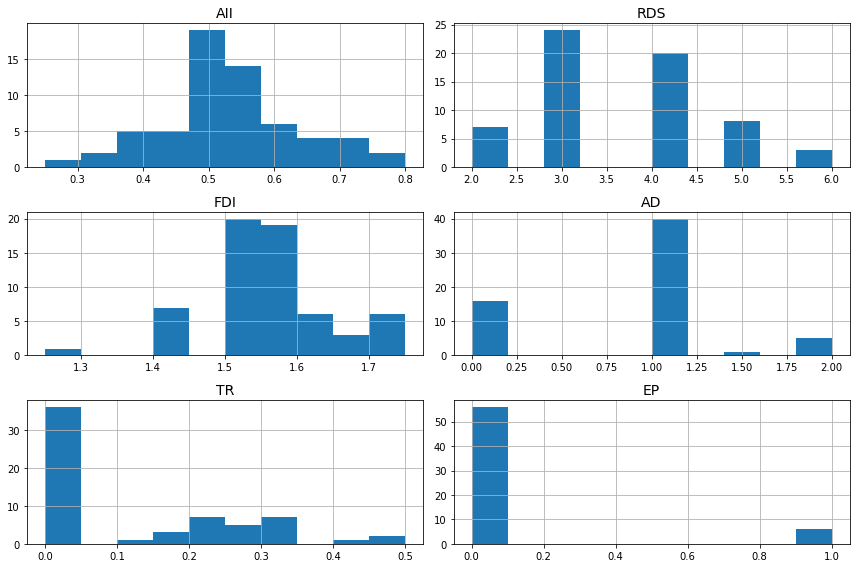

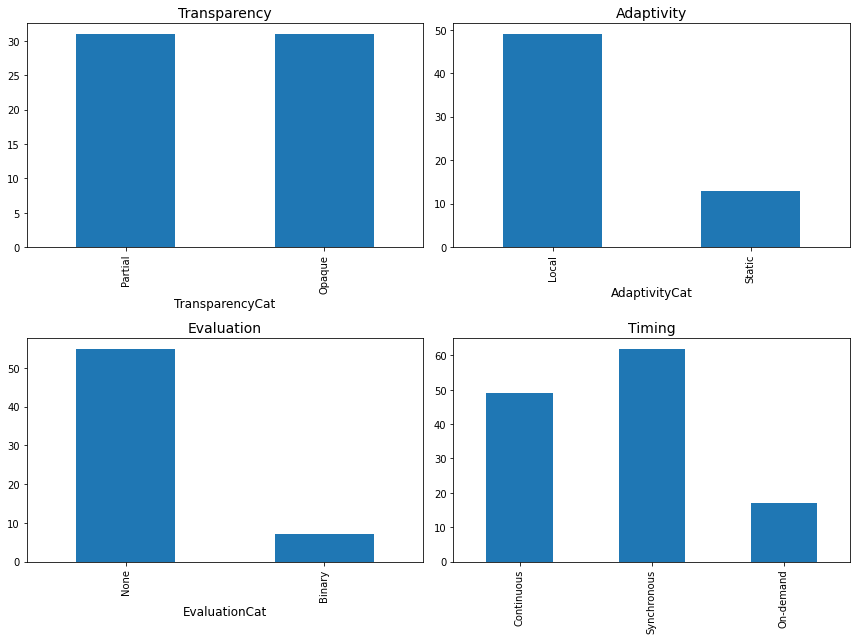

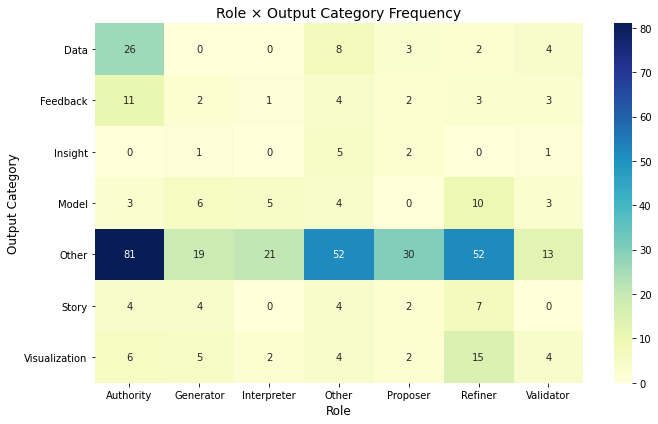

In [8]:

# Distributions
metrics_df[["AII","RDS","FDI","AD","TR","EP"]].hist(bins=10, figsize=(12,8)); plt.tight_layout(); plt.show()

# Timing/Initiative/Manner presence
fig, axes = plt.subplots(2,2, figsize=(12,9))
metrics_df["TransparencyCat"].value_counts().plot(kind="bar", ax=axes[0,0], title="Transparency")
metrics_df["AdaptivityCat"].value_counts().plot(kind="bar", ax=axes[0,1], title="Adaptivity")
metrics_df["EvaluationCat"].value_counts().plot(kind="bar", ax=axes[1,0], title="Evaluation")
pd.Series(Counter(", ".join(metrics_df["Timing"]).split(", "))).drop("", errors="ignore").plot(kind="bar", ax=axes[1,1], title="Timing")
plt.tight_layout(); plt.show()

# Role x Output heatmap
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Role × Output Category Frequency")
plt.ylabel("Output Category"); plt.xlabel("Role")
plt.tight_layout(); plt.show()


## 8. Motif analysis

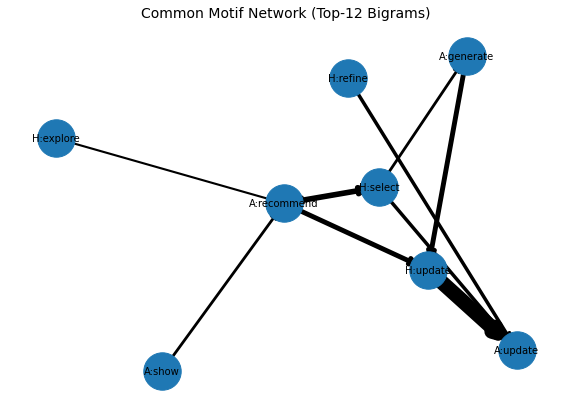

In [9]:

# Bigram motifs over normalized labels
bigrams = Counter()
for uml in df['UML_normalized']:
    labels = [f"{src}:{verb}" for src,_,verb,_ in parse_triples(uml)]
    for i in range(len(labels)-1):
        bigrams[(labels[i], labels[i+1])] += 1

# Visualize top-12 bigrams as a graph
G = nx.DiGraph()
for (u,v), w in bigrams.most_common(12):
    G.add_edge(u, v, weight=w)
plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, k=0.8, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=1400)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=[G[e[0]][e[1]]['weight']*0.7 for e in G.edges()], arrowsize=15)
plt.title("Common Motif Network (Top-12 Bigrams)")
plt.axis("off"); plt.show()


## 9. Control-structure × Metrics

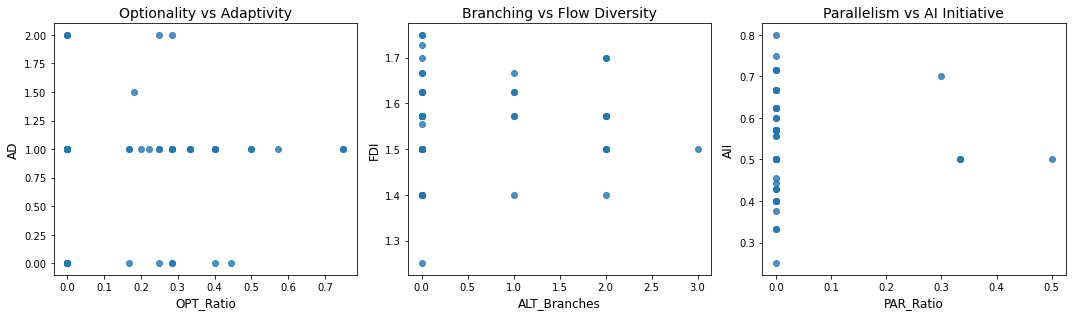

{'OPT_presence_rate': 0.4838709677419355,
 'ALT_presence_rate': 0.27419354838709675,
 'PAR_presence_rate': 0.08064516129032258,
 'mean_OPT_ratio': 0.16483731322441003,
 'mean_ALT_ratio': 0.11513056835637482,
 'mean_PAR_ratio': 0.029032258064516127}

In [10]:

# Merge and analyze
joined = blocks_df.merge(metrics_df, on="Title", how="left")

# Presence
joined[["HasOPT","HasALT","HasPAR"]].sum()

# Scatter relations
fig, axes = plt.subplots(1,3, figsize=(15,4.5))
axes[0].scatter(joined["OPT_Ratio"], joined["AD"], alpha=0.8); axes[0].set_title("Optionality vs Adaptivity"); axes[0].set_xlabel("OPT_Ratio"); axes[0].set_ylabel("AD")
axes[1].scatter(joined["ALT_Branches"], joined["FDI"], alpha=0.8); axes[1].set_title("Branching vs Flow Diversity"); axes[1].set_xlabel("ALT_Branches"); axes[1].set_ylabel("FDI")
axes[2].scatter(joined["PAR_Ratio"], joined["AII"], alpha=0.8); axes[2].set_title("Parallelism vs AI Initiative"); axes[2].set_xlabel("PAR_Ratio"); axes[2].set_ylabel("AII")
plt.tight_layout(); plt.show()

# Quick numeric summary
summary = {
    "OPT_presence_rate": float(joined["HasOPT"].mean()),
    "ALT_presence_rate": float(joined["HasALT"].mean()),
    "PAR_presence_rate": float(joined["HasPAR"].mean()),
    "mean_OPT_ratio": float(joined["OPT_Ratio"].mean()),
    "mean_ALT_ratio": float(joined["ALT_Ratio"].mean()),
    "mean_PAR_ratio": float(joined["PAR_Ratio"].mean()),
}
summary


## 10. Save artifacts

In [12]:

# Export normalized flows + metrics (for paper appendix)
export_df = df[["Title","UML_normalized"]].merge(metrics_df, on="Title")
export_path = "./normalized_flows_with_metrics.ipynb_export.csv"
export_df.to_csv(export_path, index=False, encoding="utf-8")
export_path


'./normalized_flows_with_metrics.ipynb_export.csv'


## 11. Findings and CHI-oriented takeaways

本节汇总上文所有图表与表格的关键结果，并给出面向 CHI 的设计启示。为避免信息丢失，数值均来自本 Notebook 中的计算。

### 11.1 Quantitative summary
1. 主动性  
   AII 平均值约为 0.537  
   RDS 平均值约为 3.61  
   解释 人与 AI 的动作数量较为均衡 AI 略主动 系统通常包含三到四种协作角色

2. 结构多样性与适应性  
   FDI 平均值约为 1.55  
   AD 平均值约为 0.83  
   解释 多数系统复用相似的交互模式 以短链的更新循环为主

3. 透明性与显式评价  
   TR 平均值约为 0.113  
   EP 比率约为 0.097  
   解释 AI 解释性与用户显式评价在现有系统中较少出现

4. 控制结构  
   HasOPT 出现率约为 0.484  OPT_Ratio 平均值约为 0.165  
   HasALT 出现率约为 0.274  ALT_Ratio 平均值约为 0.115  ALT_Branches 多为低值  
   HasPAR 出现率约为 0.081  PAR_Ratio 平均值约为 0.029  
   解释 可选流程较常见 分支与并行显著不足

### 11.2 Role × Output 的阶段性模式
1. Data 准备阶段  
   Human 以 Authority 为主 AI 少量承担 Interpreter 或 Proposer  
   设计含义 在数据选择与清洗上应优先保证用户控制权并为 AI 的解析过程提供可见性

2. Model 计算阶段  
   AI 主导 Generator 与 Refiner Human 以 Validator 为辅  
   设计含义 需要更强的解释与不确定性表达 才能支撑人对模型的校验

3. Visualization 探索阶段  
   AI 常生成与更新可视化 Human 负责选择与微调  
   设计含义 这是最典型的混合主动阶段 需要高频往复且低摩擦的编辑工具

4. Insight 与 Story 阶段  
   AI 作为 Proposer 生成候选事实或叙事片段 Human 进行修正与确认  
   设计含义 适合采用提案式共创与可回溯的版本管理

### 11.3 拓扑结构 archetypes
1. 推荐循环  
   AI 推荐  Human 选择  AI 更新  
   这一循环解释了 On demand 与 Human Authority 的共存

2. 编辑循环  
   AI 生成  Human 更新  AI 更新  
   这一循环解释了 Continuous 与 Local adaptivity 的普遍存在

### 11.4 CHI 领域的设计启示
1. 透明解释与显式验证  
   增加 AI explain 与 Human validate 的闭环 以提高 TR 与 EP 并在流程网络中形成稳定链路

2. 并行与分支协作  
   引入人机并行探索与高差异的分支方案 促进真正的结构多样性 提升 FDI 与 PAR 相关指标

3. 阶段化混合策略  
   按 Data  Model  Visualization  Insight 的阶段分别分配主动性与权限 避免一刀切的交互模型

4. 交互原型库与可复用组件  
   将推荐循环与编辑循环抽象为可复用部件 支持设计者组合并扩展到挑战假设 与对话式协商等新原型



## 13. Design Space Response

### Initiative (What)

指标：AII≈0.54、RDS≈3.6

发现：Human 保持 Authority，AI 多为 Proposer/Generator/Refiner

设计含义：系统设计应支持 多角色灵活切换，而不是固定人主 AI 辅的单一模式

### Timing (When)

指标：Opt≈0.16、Alt≈0.12、Par≈0.03

发现：大多数为同步 + 短链连续交互，opt 较常见，alt/并行不足

设计含义：未来应探索 分支探索和并行分析，突破推荐循环与编辑循环的单一节奏

### Manner (How)

指标：TR≈0.11、EP≈0.10、AD≈0.83

发现：透明性与显式评价不足，适应性局限于本地更新

设计含义：应当增加 解释–验证闭环、支持 全局适应，推动 AI 不仅帮忙更新，还能解释、辩护、学习